# Plotting
Plot losses and development scores from Tensorboard writer.

In [112]:
%matplotlib inline

import os
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

sns.set_style('whitegrid')

In [126]:
# TODO: get the right folder here (so no in `lisa`)
MODEL_DIR = '../models/lisa'
TEMP_DIR = 'temp'
MODELS = ['disc-rnng', 'crf', 'gen-rnng', 'rnn-lm']  # temporary list
# TODO: get final list of names here:
# MODELS = ['disc-rnng', 'crf', 'gen-rnng', 'lm-multitask-span', 'lm-multitask-ccg']
TSV_PATH = 'models_log.tsv'

In [118]:
def get_all_folders():
    all_folders = [d for d in os.listdir(MODEL_DIR)
        if os.path.isdir(os.path.join(MODEL_DIR, d))
        and d != TEMP_DIR]
    return all_folders

def filter_folders(folders, name, include=[], exclude=[]):
    assert isinstance(include, list)
    assert isinstance(exclude, list)
    
    filtered = []
    for folder in folders:
        folder = folder.split('_')
        if folder[0] == name:
            if all(name in folder for name in include) and all(not name in folder for name in exclude):
                filtered.append('_'.join(folder))
    if not filtered:
        filtered.append('')

    return filtered

In [119]:
with open(TSV_PATH, 'w') as f:

    print('\t'.join((
        'model', 'seed', 'log', 'step', 'value', 'time')), file=f)

    for model in MODELS:
        folders = filter_folders(get_all_folders(), model)

        for i, folder in enumerate(folders):

            events_file = [file for file in os.listdir(os.path.join(MODEL_DIR, folder)) 
                               if file.startswith('events')][0]
            writer = EventAccumulator(os.path.join(MODEL_DIR, folder, events_file)).Reload()
            tags = writer.Tags()['scalars']

            values = defaultdict(list)
            for tag in tags:
                for event in zip(writer.Scalars(tag)):
                    event = event[0]
                    values[tag].append((event.step, event.value, event.wall_time))

            for tag in tags:
                for step, value, time in values[tag]:
                    print('\t'.join((
                        model, str(i), tag, str(step), str(value), str(time))),
                         file=f)

In [132]:
def select(dataframe, keys, values):
    assert isinstance(keys, list)
    assert isinstance(values, list)
    
    for key, value in zip(keys, values):
        dataframe = dataframe[dataframe[key] == value]
    return dataframe

In [133]:
logs = pd.read_csv(TSV_PATH, sep='\t')

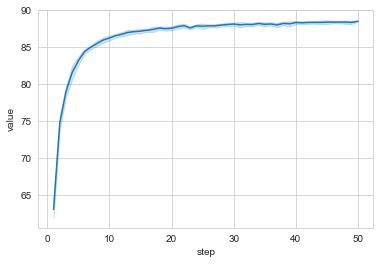

In [134]:
losses = select(logs, ['model', 'log'], ['disc-rnng', 'dev/f-score'])

sns.lineplot(data=losses, x='step', y='value', ci='sd')

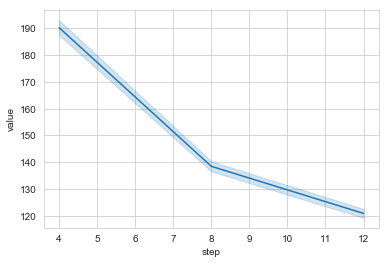

In [130]:
losses = select(logs, ['model', 'log'], ['gen-rnng', 'dev/perplexity'])

sns.lineplot(data=losses, x='step', y='value', ci='sd')

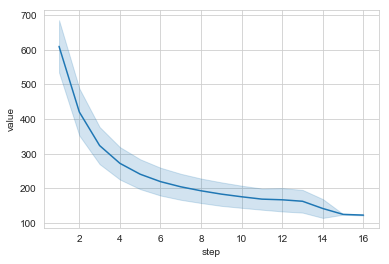

In [131]:
losses = select(logs, ['model', 'log'], ['rnn-lm', 'dev/perplexity'])

sns.lineplot(data=losses, x='step', y='value', ci='sd')